# Tile masking
Masking is a common operation to use when performing analysis across tiles. Tile masking allows one to compare two tiles, a value tile and a masking tile. The masking tile can be thought of as being placed on top of the other tile, obscuring certain values. Masking cells set to NODATA are opaque, and cells that are anything else are transparent. In this way, value cells that correspond to masking cells that are NODATA become NODATA and value cells corresponding to other values are untouched.

Initial setup:

In [1]:
from pyrasterframes import *
from pyrasterframes.rasterfunctions import *
import pyspark
from pyspark.sql import SparkSession
from pathlib import Path
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

spark = SparkSession.builder. \
    master("local[*]"). \
    appName("RasterFrames"). \
    config("spark.ui.enabled", "false"). \
    getOrCreate(). \
    withRasterFrames()
    
sc = spark.sparkContext

resource_dir = Path('./samples').resolve()
# Utility for reading imagery from our test data set
filenamePattern = "L8-B{}-Elkton-VA.tiff"
bandNumbers = range(1, 5)
bandColNames = list(map(lambda n: 'band_{}'.format(n), bandNumbers))

def readTiff(band):
    return spark.read.geotiff(resource_dir.joinpath(filenamePattern.format(band)).as_uri())

# The literal column will be used to perform a join later
from functools import reduce
joinedRF = reduce(lambda rf1, rf2: rf1.asRF().spatialJoin(rf2),
                  [readTiff(b).withColumnRenamed('tile', 'band_{}'.format(b)) for b in bandNumbers]) \
                  .drop('bounds', 'metadata').asRF()

joinedRF.show()

+-----------+--------------------+--------------------+--------------------+--------------------+
|spatial_key|              band_1|              band_2|              band_3|              band_4|
+-----------+--------------------+--------------------+--------------------+--------------------+
|      [0,0]|geotrellis.raster...|geotrellis.raster...|geotrellis.raster...|geotrellis.raster...|
+-----------+--------------------+--------------------+--------------------+--------------------+



In order to create a mask array we are going to make an array out of the values of our tile and run it through a threshold function that will assign `NODATA` if the cell value is below a certain amount.

In [2]:
rastArray = joinedRF.toDoubleRaster("band_1", 186, 169)

thresholdArr = []
for i in range(0, 31434):
    if rastArray[i] > 10500:
        thresholdArr.append(1.0)
    else:
        thresholdArr.append(np.NaN)

We will turn this array into a dataframe to join it with our existing rasterframe.

In [3]:
df = sc.parallelize([list([thresholdArr])]).toDF()

We create a tile in our dataframe as well as a column with nothing but the value 1 in it, for joining purposes.

In [4]:
from pyspark.sql.functions import lit
tiledDF = df.withColumn("maskTile", arrayToTile("_1", 186, 169)).withColumn("joinCol", lit(1))
tiledDF.show()

+--------------------+--------------------+-------+
|                  _1|            maskTile|joinCol|
+--------------------+--------------------+-------+
|[NaN, NaN, NaN, N...|DoubleRawArrayTil...|      1|
+--------------------+--------------------+-------+



We create a similar column in `joinedRF`.

In [5]:
joinedRF = joinedRF.withColumn("joinCol", lit(1))

The cell type here is initially raw, which means that it does not support any NODATA value, which is a requirement for masking. We use `convertCellType` to change the type away from raw.

In [6]:
joinedRF.select(cellType("band_2")).show()

joinedRF = joinedRF.withColumn("band_2_ND", convertCellType("band_2", 'uint16'))

joinedRF.select(cellType("band_2_ND")).show()

+--------------------------+
|celltypeexpression(band_2)|
+--------------------------+
|                 uint16raw|
+--------------------------+

+-----------------------------+
|celltypeexpression(band_2_ND)|
+-----------------------------+
|                       uint16|
+-----------------------------+



We now join the original RF together with the dataframe containing the mask tile.

In [7]:
withMaskedTile = joinedRF.join(tiledDF, joinedRF["joinCol"] == tiledDF["joinCol"], how="outer")

Like we did before, it's imporant to convert the `cellType` of our maskTile away from raw because we need `NODATA` values to properly mask.

In [8]:
withMaskedTile = withMaskedTile.withColumn("maskTileND", convertCellType("maskTile", 'uint16'))

Clearly the conversion was successful because there are 28570 `noDataCells` in `maskTileND`.

In [9]:
withMaskedTile.select(noDataCells("maskTileND")).show()

+-----------------------+
|noDataCells(maskTileND)|
+-----------------------+
|                  28570|
+-----------------------+



## Mask 
Mask is an operation that takes two tiles and eliminates data from one cell that corresponds to a value in the other. For instance, if a cell in the masking tile contains a `NODATA`, the corresponding cell in the other tile would be set to `NODATA`, like in the following diagram where the first tile is the masking tile, the second tile is the other tile, and the final tile is the output tile.

![-](pics/mask.png)

If the masking cell contained anything else, the corresponding cell would have its value untouched. The mean is thus high, since all cells with a low reflectance were masked over with `NODATA` and thus not calculated.

In [10]:
masked = withMaskedTile \
  .withColumn("masked", mask(joinedRF["band_2_ND"], withMaskedTile["maskTileND"])).asRF()
masked.select(tileStats("masked")).show(truncate=False)

+-------------------------------------------------------------+
|tileStats(masked)                                            |
+-------------------------------------------------------------+
|[2864,-1,9630.0,22147.0,10648.890363128503,1494703.325270259]|
+-------------------------------------------------------------+



### Inverse Mask
Inverse mask works in the opposite way; It doesn't touch the cells that are set to NODATA in the masking tile and all other cells become NODATA. The mean is low for the same reason that the masked mean is high: High values were reverse masked over.

In [11]:
inversemasked = withMaskedTile \
  .withColumn("inversemasked", inverseMask(joinedRF["band_2_ND"], withMaskedTile["maskTileND"])).asRF()
inversemasked.select(tileStats("inversemasked")).show(truncate=False)

+------------------------------------------------------------+
|tileStats(inversemasked)                                    |
+------------------------------------------------------------+
|[28570,-1,8275.0,9996.0,8756.359047952406,118202.5029361604]|
+------------------------------------------------------------+



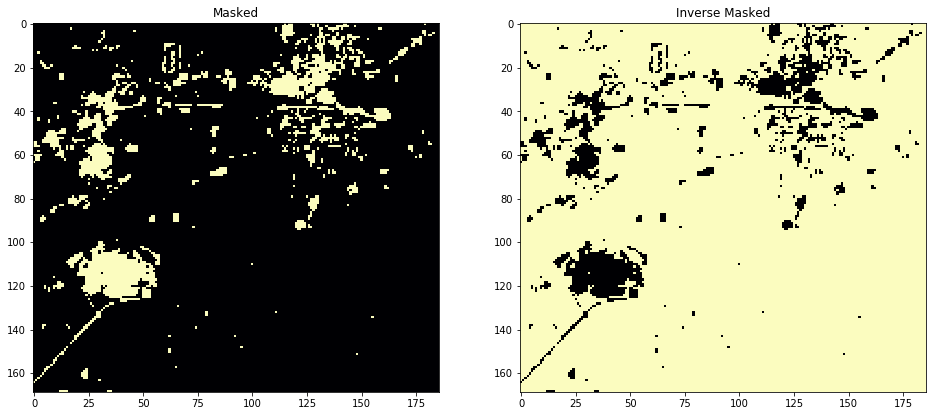

In [12]:
raster1 = np.asarray(list(masked.toIntRaster('masked', 186, 169)))
pixels1 = np.reshape(raster1, (169, 186))
raster2 = np.asarray(list(inversemasked.toIntRaster('inversemasked', 186, 169)))
pixels2 = np.reshape(raster2, (169, 186))

fig = plt.figure(figsize=(16,16))
fig.add_subplot(1, 2, 1).set_title("Masked")
imgplot = plt.imshow(pixels1)
imgplot.set_cmap('magma')
fig.add_subplot(1, 2, 2).set_title("Inverse Masked")
imgplot = plt.imshow(pixels2)
imgplot.set_cmap('magma')